# 2 - Mass spectra deduplication with Locality sensitive hashing

In [6]:
# 0) Setup: imports & project root ------------------------------------
import sys
from pathlib import Path

# so that `paths.py` (with PROJECT_ROOT) is on the import path
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
from tqdm import tqdm

from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from dreams.utils.spectra import PeakListModifiedCosine

# plotting utilities
from benchmark.utils.plots import plot_similarity_kde, plot_dissimilarity_hist_kde

#### Here we load our preprocessed data from previous tutorial 1_data_preparation.ipynb
#### If you do note have hdf5 processed file form previous, or you preprocessed your spectra by yourself and want to skip it, and load your mzML of mgf

In [8]:
raw_dir   = PROJECT_ROOT / "data" / "rawfiles"
mzml_path = raw_dir / "202312_20_P09-Leaf-r1_1uL.mzML"
h5_path   = mzml_path.with_name(mzml_path.stem + "_high_quality.hdf5")
dedup_h5  = mzml_path.with_name(mzml_path.stem + "_dedup.hdf5")

In [10]:
# 2) Load (or cache) & filter to positive‐ion spectra -----------------------
if h5_path.exists():
    msdata = MSData.from_hdf5(str(h5_path), in_mem=True)
else:
    msdata = MSData.from_mzml(str(mzml_path), in_mem=True)

Loading dataset 202312_20_P09-Leaf-r1_1uL_high_quality into memory (2000 spectra)...


### 2) Compute LSH hashes

We reuse a single LSHProjector for all spectra to guarantee consistent hash space.

In [11]:
# 1a) extract the raw spectra array (shape: N × 2 × n_peaks)
specs = msdata.get_spectra()

# 1b) instantiate the projector and compute hashes
lsh_proj = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)
hashes   = lsh_proj.compute(specs)

print(f"▶ Computed {len(hashes)} hashes; example hash: {hashes[0]!r}")


Computing LSHs: 100%|██████████| 2000/2000 [00:00<00:00, 2848.20it/s]


▶ Computed 2000 hashes; example hash: b'786a202663fa5e0a28a584694ad780c327417a5905f0950b45a6332e77bf3ebf'


#### Hashes overview

In [12]:
# ### 2) Cluster size overview
#
# How many unique hashes, and what are the top cluster sizes?

ls     = pd.Series(hashes)
counts = ls.value_counts()

print("▶ Total unique hashes (clusters):", counts.size)
print("▶ Top 5 cluster sizes:")
print(counts.head())

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_36456/3903886061.py:6: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = ls.value_counts()


▶ Total unique hashes (clusters): 1558
▶ Top 5 cluster sizes:
b'ef16f8bfe1080ba252d4ae2b4b04104c1d62b1aa022ccfa2ae0abb3557964b1e'    35
b'27d54b33fc782095d6c75cffe721f7173876722dfa00a4c5050f945d582afdca'    33
b'492a784b253fbf54dbe9ad2f81f7736163911214034dd35558801f3d0025f1ad'    30
b'4a3d93bd42db864a3069c767b2170396488129bdbea4beae082d36a49e720d20'    26
b'165b803a1c6f2a52f842388fde1ea2edfa76d01b6f473b224c0c07e073144d39'    21
Name: count, dtype: int64


#### Pick clustered hash containing 5 spectra

In [14]:
# 3a) pick a hash with cluster size == 5
small_hash = counts[counts == 5].index
assert len(small_hash) > 0, "No cluster of size 5 found!"
small_hash = small_hash[0]
small_idxs = np.where(hashes == small_hash)[0]
print(f"▶ Small cluster hash {small_hash!r} at indices", small_idxs)

▶ Small cluster hash b'2da92fe46ab16a9e0c64160b44e2341ba03ffac11c4b993c14ce7f8f0c332582' at indices [1388 1412 1677 1905 1912]


#### We investigate mass spectra by plotting them

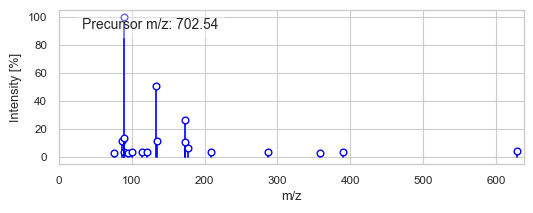

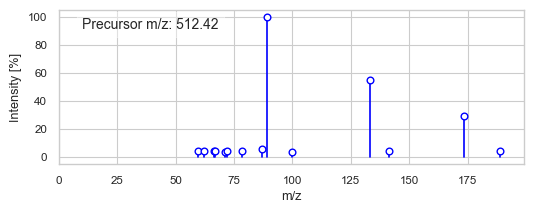

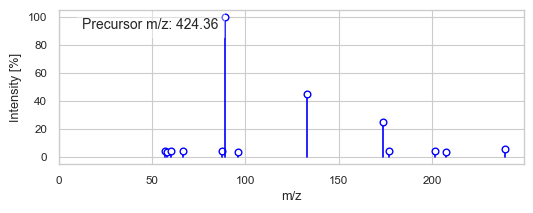

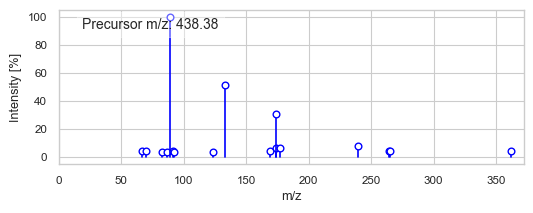

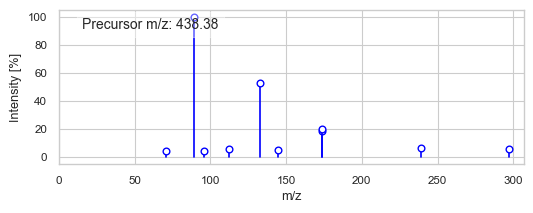

In [15]:
# 3b) plot each of the 5 spectra
for raw_i in small_idxs:
    i = int(raw_i)
    msdata.at(i, plot_mol=True)

#### We plot pairwise similarity matrix of cosine of two spectra and we see all mass spectra are highly similar

In [16]:
# 3c) compute & print their pairwise modified-cosine matrix
cos_sim = PeakListModifiedCosine()
sim_mat_small = cos_sim.compute_pairwise(
    specs    = specs[small_idxs.astype(int)],
    prec_mzs = msdata.get_values('precursor_mz')[small_idxs.astype(int)],
    avg      = False
)
print("▶ Small cluster pairwise matrix:\n", sim_mat_small)


▶ Small cluster pairwise matrix:
 [[1.         0.97112976 0.96833597 0.96981015 0.96811989]
 [0.97112976 1.         0.9827793  0.98127913 0.97087647]
 [0.96833597 0.9827793  1.         0.98478298 0.9738154 ]
 [0.96981015 0.98127913 0.98478298 1.         0.97735311]
 [0.96811989 0.97087647 0.9738154  0.97735311 1.        ]]


### 3) Find a cluster of size 15–20

We want to show that indeed clustered spectra are similar
Group spectra by identical hash, then pick one group whose size falls in our target range.

In [17]:
# count frequencies of each hash
counts = pd.Series(hashes).value_counts()

target = counts[(counts >= 15) & (counts <= 20)]
assert not target.empty, "No cluster in the desired size range found!"

# pick the first matching hash
cluster_hash = target.index[0]
cluster_size = target.iloc[0]
print(f"Selected hash {cluster_hash} with cluster size = {cluster_size}")

# indices of spectra in this cluster
i_idxs = np.where(hashes == cluster_hash)[0]

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_36456/3377724960.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = pd.Series(hashes).value_counts()


Selected hash b'a857dfeaf75b6dc7684df1f02ae0887d0e0201e6dab5653ed700a882adddbda4' with cluster size = 17


### 4) Visualize intra‑cluster similarity

Compute pairwise modified cosine similarities,to see that spectra within cluster are highly similar then plot:


Pairwise modified‑cosine matrix shape: (17, 17)


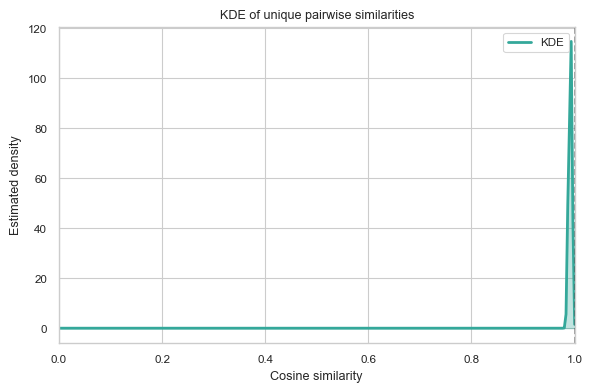

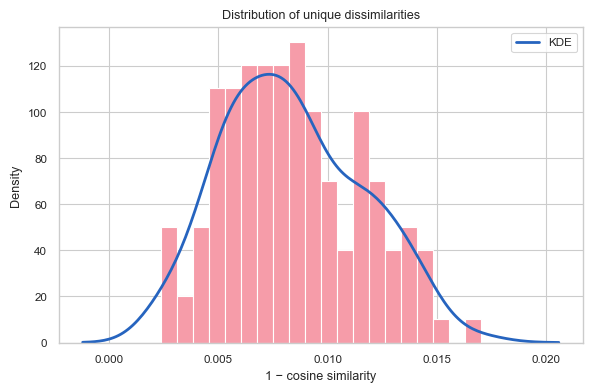

In [18]:
# extract the actual peak lists and precursor m/z for the cluster
cluster_specs = specs[i_idxs]
cluster_prec  = msdata.get_prec_mzs()[i_idxs]

# compute full pairwise similarity matrix
cos_sim = PeakListModifiedCosine()
sim_mat = cos_sim.compute_pairwise(
    specs    = cluster_specs,
    prec_mzs = cluster_prec,
    avg      = False
)
print("Pairwise modified‑cosine matrix shape:", sim_mat.shape)

# 4a) Teal KDE of the similarities
plot_similarity_kde(sim_mat, palette_idx=(1,))

# 4b) Pink histogram + lavender KDE of the affinities
plot_dissimilarity_hist_kde(sim_mat, hist_idx=2, kde_idx=0)

Conclusion:LSH clustering reliably groups highly similar spectra together, as evidenced by the tight intra‑cluster similarity distributions.

Next steps:– Repeat across additional files or whole merged dataset– Tune bin_step & n_hyperplanes– Integrate deduplication into downstream embedding pipelines